# Tutorial 2 - Topic & Sentiment Distributions

The main goal of this tutorial is to perform **Exploratoy Data Analysis (EDA)** on the ParlaMint dataset, focusing on a descriptive overview of **policy topics (CAP categories)** and **sentiment** in parliamentary debates. 


**Possible research questions are:**
- *Which CAP categories dominate parliamentary debates, and does the distribution differ across countries?*
- *How does average sentiment vary by topic and by country?*
- *Do party affiliation or coalition status influence the tone of debates?*

To answer these questions, the notebook introduces a series of visualizations and summary statistics:
- **Histograms and barplots** of CAP category distributions across parliaments
- **Sentiment distributions** for individual topics within a single country and across all countries
- **Comparisons of distributions by party status** (Coalition vs. Opposition)
- **Tables summarizing average sentiment** by topic and country, with export options (TSV) for further research
- **Scatterplots** linking topic prominence and sentiment, highlighting correlations between how much a topic is discussed and the tone in which it is discussed


**1. Setup & Data Loading**

This setup (installing/importing) libraries and data loading & filtering steps are the **same as in Tutorial 1**. For detailed explanations, see **Tutorial 1, Sections 1-2**.

In [2]:
# Uncomment and run the following line if you haven't installed pandas yet
# !pip install scipy

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import csv
from matplotlib.patches import Patch
from scipy.stats import spearmanr

In [4]:
# Set consistent style
sns.set_theme(style="whitegrid", font_scale=1.2)

In [5]:
# ---- 1. First, we have to increase the CSV field size limit ----
max_int = 2**31 - 1
while True:
    try:
        csv.field_size_limit(max_int)
        break
    except OverflowError:
        max_int = max_int // 10

countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES", "ES-CT", "ES-GA", "ES-PV", 
             "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", 
             "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA"] #change country codes according to your available datasets

base_dir = Path().resolve()

# ---- 2. Choose what columns to read (including CAP and sentiment columns) ----
cols_to_keep = [
    "id", "date", "lang_code", "lang", "speaker_role", "speaker_MP",
    "speaker_minister", "speaker_party", "speaker_party_name", "party_status",
    "party_orientation", "speaker_id", "speaker_name", "speaker_gender",
    "speaker_birth", "word_count", "CAP_category", "sent3_category", "sent6_category", "sent_logit"
]

# ---- 3. Define dtypes to reduce memory ----
dtypes = {
    "id": str,
    "date": str,
    "lang_code": "category",
    "lang": "category",
    "speaker_role": "category",
    "speaker_MP": "category",
    "speaker_minister": "category",
    "speaker_party": "category",
    "speaker_party_name": "category",
    "party_status": "category",
    "party_orientation": "category",
    "speaker_id": "category",
    "speaker_name": "category",
    "speaker_gender": "category",
    "speaker_birth": "Int32",
    "word_count": "Int32",
    "CAP_category": "category",
    "sent3_category": "category",
    "sent6_category": "category",
    "sent_logit": "float32"
}

# ---- 4. Create lists to accumulate filtered chunks ----
all_chunks = []

for country in countries:
    file_path = base_dir / f"ParlaMint-{country}_processed_no_text.tsv"

    # --- 4.1. Read in chunks using pandas.read_csv ----
    for chunk in pd.read_csv(file_path, sep="\t", usecols=cols_to_keep,
                             dtype=dtypes, chunksize=50_000, engine="python"):
        chunk["country"] = country
        chunk["country"] = chunk["country"].astype("category")

        # ---- 4.2. Filter MPs with regular role ----
        filtered_chunk = chunk.query("speaker_MP == 'MP' and speaker_role == 'Regular'")

        # ---- 4.3. Drop rows where CAP_category or sentiment is empty ----
        filtered_chunk = filtered_chunk[
            filtered_chunk["CAP_category"].notna() & (filtered_chunk["CAP_category"] != "") &
            filtered_chunk["sent3_category"].notna() & (filtered_chunk["sent3_category"] != "") &
            filtered_chunk["sent6_category"].notna() & (filtered_chunk["sent6_category"] != "")
        ]

        # ---- 4.4. Accumulate filtered chunks ----
        if not filtered_chunk.empty:
            all_chunks.append(filtered_chunk)

# ---- 5. Concatenate all accumulated chunks into DataFrames ----
filtered_all = pd.concat(all_chunks, ignore_index=True)
del all_chunks
print("All filtered:", filtered_all.shape)

All filtered: (4225608, 21)


In [6]:
filtered_all["CAP_category"] = filtered_all["CAP_category"].astype("category")
filtered_all = filtered_all[~filtered_all["CAP_category"].isin(["Mix", "Other"])]


In [7]:
filtered_all["CAP_category"] = filtered_all["CAP_category"].cat.remove_unused_categories()

**2. CAP Category Distributions**

**2.1. Selected countries**

Instead of looking at all 20+ parliaments combined, we focus on a few **selected countries** to make comparisons easier. 

By limiting the scope to 2-3 countries at a time, we can spot similarities and differences without overwhelming the plots. 

C:\Users\isabe\AppData\Local\Temp\ipykernel_21848\1378084540.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(


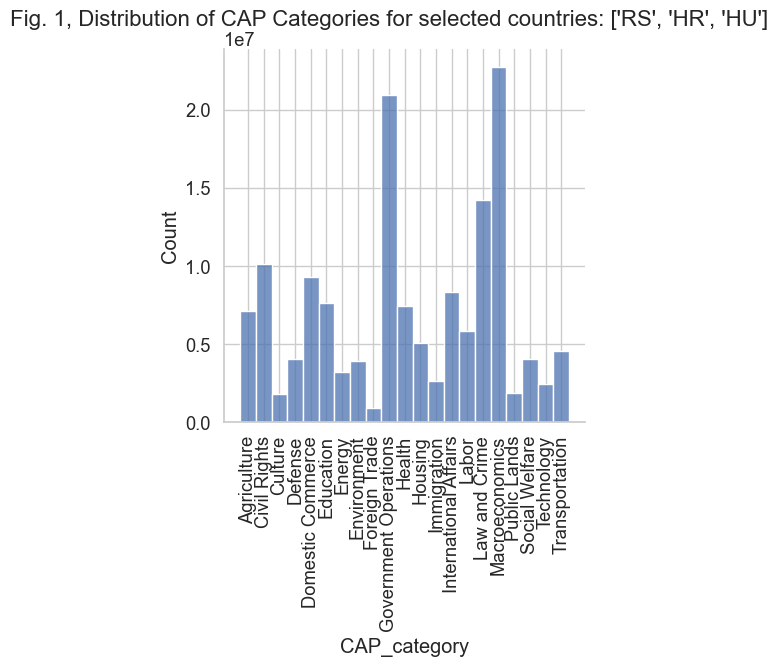

In [8]:
#Example: select 3 countries to compare
selected_countries = ["RS", "HR", "HU"]
filtered_subset = filtered_all[filtered_all["country"].isin(selected_countries)]

g = sns.displot(
    data=filtered_subset.sort_values("CAP_category"),
    x="CAP_category",
    weights=filtered_all["word_count"],
    palette="Set2" 
)

cap_order = sorted(filtered_all["CAP_category"].unique()) #defines order of CAP labels on x axis

g.set_xticklabels(rotation=90)  # rotate x-axis labels
g.fig.suptitle(f"Fig. 1, Distribution of CAP Categories for selected countries: {selected_countries}", fontsize=16)
g.fig.subplots_adjust(top=0.9)

*Figure 1 shows that topics like "Macroeconomics" and "Government Operations" are discussed the most across the selected parliaments. But what does it look like on one country level?*

**2.2. Per-country (example: Serbia)**

To get even more concrete insights, we zoom in on **one country**. Here, we use **Serbia (RS)** as an example because:
- It has a relatively large number of speeches in the dataset.
- It represenets a non-EU parliament, which can be contrasted with EU member states.
- Due to its structural similarities with neighboring countries, it provides an interesting case for regional comparison.


C:\Users\isabe\AppData\Local\Temp\ipykernel_21848\1594046351.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(


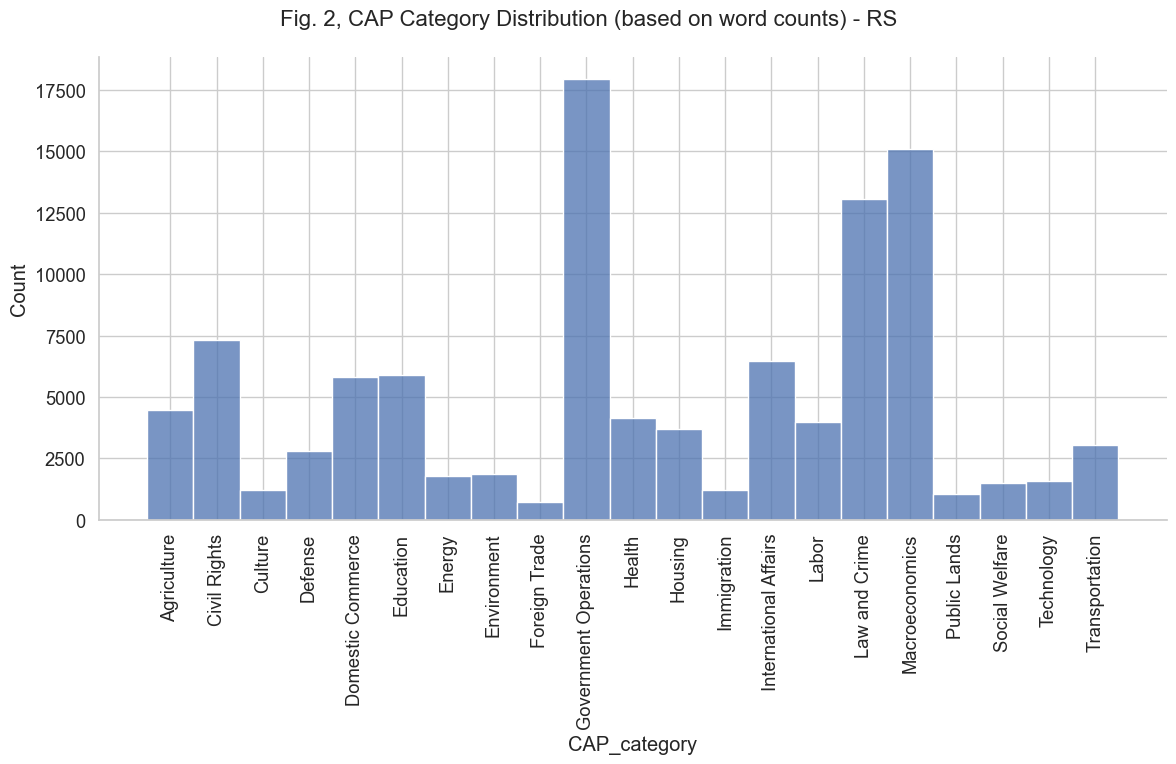

In [9]:
#Example: focus on one country
country = "RS"
filtered_by_country = filtered_all[filtered_all["country"] == country]

filtered_by_country = filtered_all[filtered_all["country"] == "RS"]  

g = sns.displot(
    data=filtered_by_country.sort_values("CAP_category"),
    x="CAP_category",
    height=6,
    aspect=2,
    palette="Set2"
)

cap_order = sorted(filtered_by_country["CAP_category"].unique())

g.set_xticklabels(rotation=90)
g.fig.suptitle("Fig. 2, CAP Category Distribution (based on word counts) - RS", fontsize=16)
g.fig.subplots_adjust(top=0.9)  


*In this example, it shows that the Serbian parliament devotes most of its time to debate "Government Operations" and "Macroeconimics", as well as "Law and Crime", similar to the distribution of 2.1.. If you want to research the distribution for other countries, just change the country abbreviation in the code above.*

**3. Sentiment by Party & Orientation**

After examining the **distribution of CAP categories** across selected countries and focused on Serbia (RS) as an illustrative example, we will exlore the **sentiment of the debates**. This section examines how positive, neutral or negative tones are distributed across topics and parties, helping us understand the emotional dynamics of parliamentary discussions.

**3.1. Sentiment distribution across topics for a single country**

Before analyzing sentiment by party or coalitions status, it is useful to look at the **overall sentiment distribution across CAP topics** in a single country. Here, we will look at **Serbia (RS)**, which we already selected for the previous analysis of CAP category distribution (see 2.2.). 

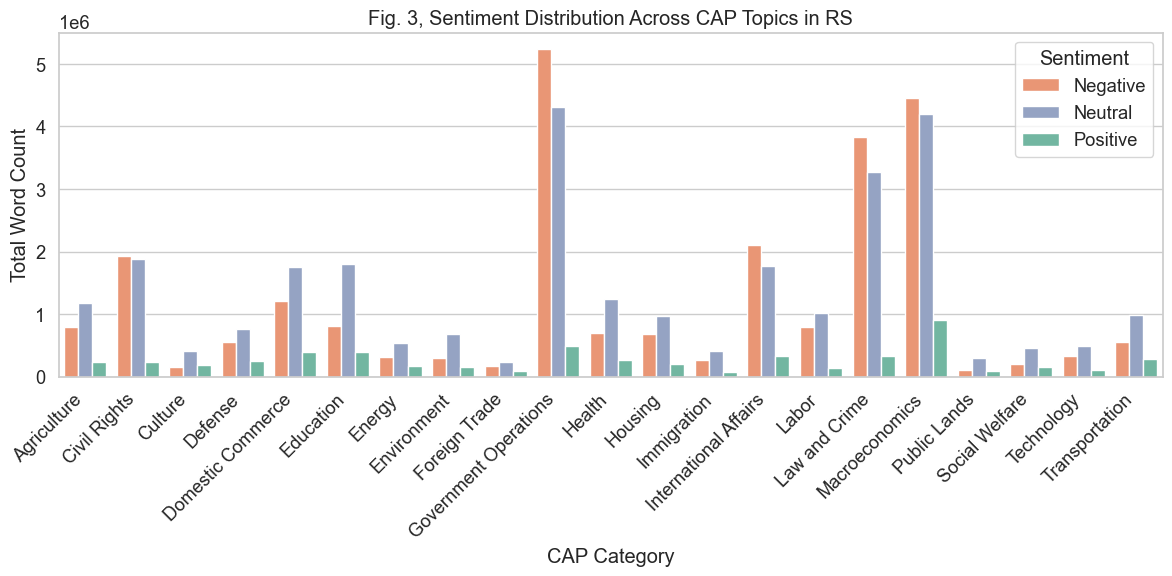

In [20]:
# ---- 1. Filter data for one country ----
country = "RS"  # change to your country of interest
country_data = filtered_all[filtered_all["country"] == country]

# ---- 2. Aggregate word counts by CAP_category and sentiment ----
cap_sent_counts = (
    country_data
    .groupby(["CAP_category", "sent3_category"], observed=True)["word_count"]
    .sum()
    .reset_index()
)

# ---- 3. Ensure CAP_category is ordered consistently ----
cap_order = sorted(country_data["CAP_category"].unique())
cap_sent_counts["CAP_category"] = pd.Categorical(
    cap_sent_counts["CAP_category"],
    categories=cap_order,
    ordered=True
)

# ---- 4. Plot ----
plt.figure(figsize=(12,6))

set2 = sns.color_palette("Set2")
custom_palette = {
    "Negative": set2[1], 
    "Neutral": set2[2],
    "Positive": set2[0]
}

sns.barplot(
    data=cap_sent_counts,
    x="CAP_category",
    y="word_count",
    hue="sent3_category",
    palette=custom_palette
)

plt.title(f"Fig. 3, Sentiment Distribution Across CAP Topics in {country}")
plt.xlabel("CAP Category")
plt.ylabel("Total Word Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


*For Serbia, we can identify that the distribution of negative and neutral tone is quite balanced across topics. In the cases of the most discussed topics, such as 'Government Operations', 'Macroeconomics' and 'Law and Crime', we see that negative sentiment tends to dominate these debates. These patterns could be investigated further, for example by comparing these trends with other countries in the dataset (see 3.2.) or by analyzing how sentiment varies across **party status** (Coalition vs. Opposition) (see 3.4.) or **party orientation** (see 3.5.).*

**3.2. Sentiment Distribution across topics for selected countries**

After exploring sentiment patterns within a single country (RS), we can now expand the analysis to **multiple countries** - for examples, **Serbia (RS), Croatia (HR) and Hungary (HU)**.

The next code aims to visualize the distribution of positive, neutral and negative sentiment for each CAP topic across the selected parliaments.

By comparing the topic distribution across parliaments, we can identify:
- Which topics tend to evoke more negative or positive language overall.
- How sentiment patterns differ from the single-country perspective, revealing both common trends and country-specific deviations.


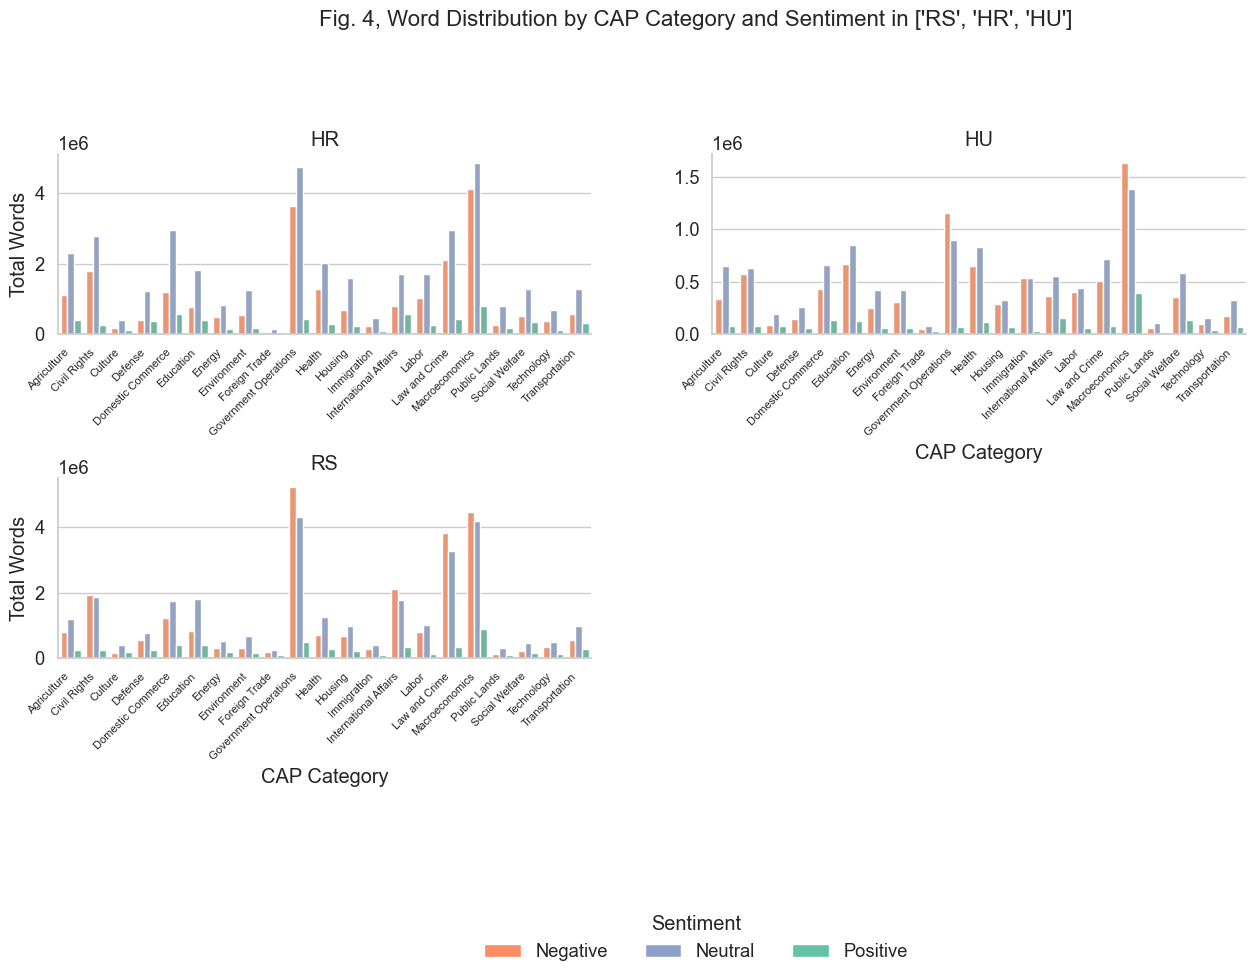

In [23]:
# ---- 1. Filter for selected countries & aggregate word counts by CAP, sentiment and country ----
selected_countries = ["RS", "HR", "HU"]
cap_sent_country = (
    filtered_all[filtered_all["country"].isin(selected_countries)]
    .groupby(["country", "CAP_category", "sent3_category"], observed=True)
    .agg(total_words=("word_count", "sum"))
    .reset_index()
)

# ---- 2. Ensure CAP_category is categorical with fixed order ----
cap_order = sorted(cap_sent_country["CAP_category"].unique())
cap_sent_country["CAP_category"] = pd.Categorical(
    cap_sent_country["CAP_category"],
    categories=cap_order,
    ordered=True
)

# ---- 3. Plot: CAP × sentiment stacked per country ----
set2 = sns.color_palette("Set2")
custom_palette = {
    "Negative": set2[1],  # orange
    "Neutral": set2[2],   # blue
    "Positive": set2[0]   # green
}

g = sns.catplot(
    data=cap_sent_country,
    x="CAP_category",
    y="total_words",
    hue="sent3_category",
    col="country",
    kind="bar",
    height=4,
    aspect=1.6,
    col_wrap=2,
    sharey=False,
    sharex=False,  
    order=cap_order,
    palette=custom_palette
)

# ---- 3.1. Rotate xticklabels ----
for ax in g.axes.flatten():
    ax.set_xticks(range(len(cap_order)))
    ax.set_xticklabels(cap_order, rotation=45, ha="right", fontsize=8)

g.set_axis_labels("CAP Category", "Total Words")
g.set_titles("{col_name}")

# ---- 3.2. Remove default legend ----
if g._legend:
    g._legend.remove()

# ---- 3.3. Create a **clean legend on top** ----
hue_order = ["Negative", "Neutral", "Positive"]  # enforce consistent order
legend_elements = [
    Patch(facecolor=custom_palette[sent], label=sent) 
    for sent in hue_order
]

g.fig.legend(
    handles=legend_elements,
    loc='upper center',
    ncol=len(hue_order),
    frameon=False,
    bbox_to_anchor=(0.5, -0.05),
    title="Sentiment"
)

# ---- 3.4. Adjust spacing to reduce top margin ----
g.fig.subplots_adjust(top=0.88, bottom=0.25, hspace=0.8)
g.fig.suptitle(
    f"Fig. 4, Word Distribution by CAP Category and Sentiment in {selected_countries}",
    fontsize=16,
    y=1.06
)

plt.show()


*These plots show that the distribution of sentiment can vary from parliament to parliament. Interestingley, the neutral and negative tones dominate the debates across most topics.*

*'Government Operations', 'Macroeconomics' and 'Law and Crime' consistently have the highest word counts and are mostly characterized by negative and neutral sentiment.*

*Comparing countries, Serbia (RS) shows a slightly higher proportion of neg. tone in 'Macroeconomics' and 'Law and Crime', while Hungary (HU) has more neutral contributions in 'Public Welfare' and 'Health'.*

These trends and country-specific differences can be further explored by looking at the distribution of one country across parties, orientations or coalition status.

**3.3. By party in one country (example: Serbia)**

The next code examines **sentiment distribution** by **party** in a single country - here, Serbia - to identify which parties contribute more positive, neutral or negative tone. As shown in Fig. 4, Serbia displays a wider range of sentiment across CAP categories than the other countries, making it an interesting case to see whether this pattern might show at the party level as well.

In the code, we apply a threshold of 1% (see section 4 in the code) of the total word count to focus on parties with a meaningful contribution. This removes smaller parties with minimal speaking time which makes the visualization clearer (it doesn't show all 40+ parties) and easier to interpret.

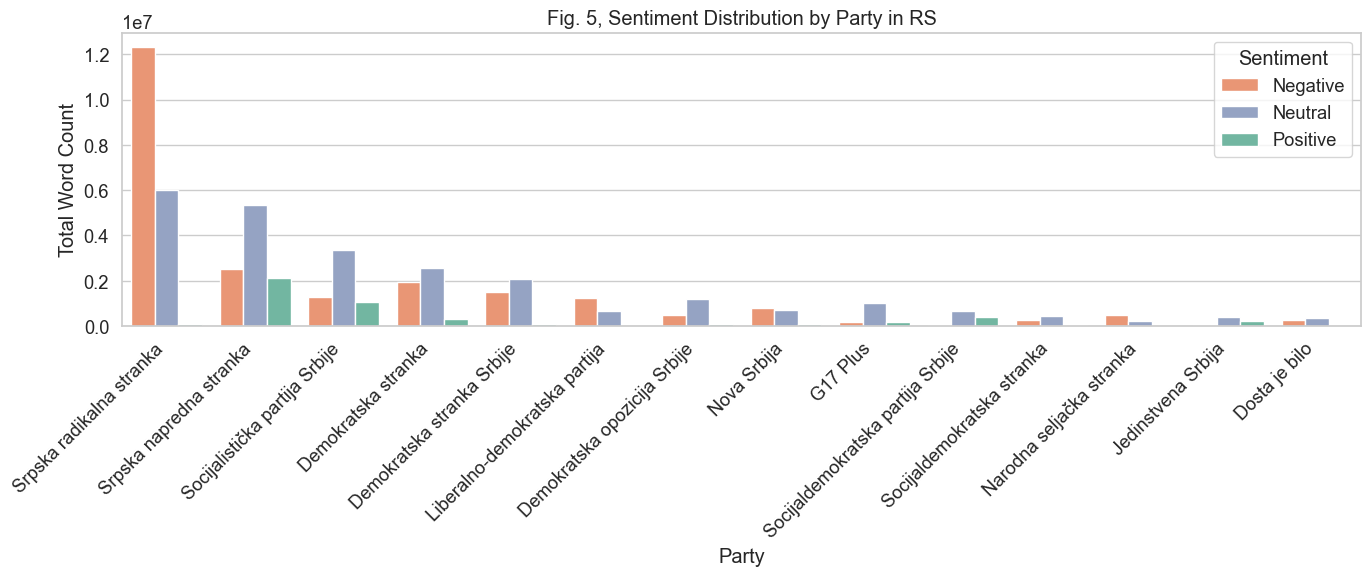

In [24]:
# ---- 1. Filter the data for one country ----
country = "RS"
country_data = filtered_all[filtered_all["country"] == country].copy()

# ---- 2. Aggregate word count by party and sentiment ----
agg_counts = (
    country_data
    .groupby(["speaker_party_name", "sent3_category"], observed=True)["word_count"]
    .sum()
    .reset_index()
)

# ---- 3. Calculate total words per party ----
party_totals = agg_counts.groupby("speaker_party_name")["word_count"].sum()

# ---- 4. Set threshold (e.g., 5% of total words in country) ----
threshold = 0.01 * party_totals.sum()
significant_parties = party_totals[party_totals >= threshold].index

# ---- 5. Filter agg_counts to include only significant parties ----
agg_counts_filtered = agg_counts[agg_counts["speaker_party_name"].isin(significant_parties)]

# ---- 6. Sort parties by total word count ----
party_order = (
    agg_counts_filtered.groupby("speaker_party_name")["word_count"].sum()
    .sort_values(ascending=False)
    .index
)

# ---- 7. Plot ----
plt.figure(figsize=(14, 6))

set2 = sns.color_palette("Set2")
custom_palette = {
    "Negative": set2[1], 
    "Neutral": set2[2],
    "Positive": set2[0]
}

sns.barplot(
    data=agg_counts_filtered,
    x="speaker_party_name",
    y="word_count",
    hue="sent3_category",
    palette=custom_palette,
    order=party_order
)

plt.title(f"Fig. 5, Sentiment Distribution by Party in {country}")
plt.xlabel("Party")
plt.ylabel("Total Word Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


*As shown in Fig. 5, the nationalist right-orientated **Srpska radikalna stranka** (*Serbian Radical Party*, SRS) stands out both in word count and in negative sentiment, with roughly two thirds of their speeches carrying a negative tone. In contrast, the major ruling center-right **Srpska napredna stranka** (*Serbian Progressive Party*, SNS) debates in a much less negative manner: neutral tone dominates and the party contributes the largest share of positive speech overall. In the next section, we will see that this reflects a broader pattern: ruling parties tend to express more positive sentiment, while opposition parties are generally more negative.*

**3.4. Coalition vs. Opposition (example: Serbia)**

Before analyzing the sentiment of coalition and opposition parties, it is essential to understand their **relative contribution** to the parliamentary debate. Fig. 6a displays the total word count allocated to each party status group ("Opposition" / "Coalition" / "-") in the Serbian parliament.

This visualization helps to establish the balance of the discoursive power. A dominant coalition might set the overall tone of debates, while a vocal opposition could shape discourse through criticism. Understanding this distribution is important to interpreting the subsequent sentiment analysis (Fig. 6b) because the tone of a group that speaks frequently carries more weight than that of a group with minimal speaking time.

*Note: The "-" category appears for speeches where party status could not be determined or does not clearly fall into "Coalition" or "Opposition". This may include independent MPs, temporary members, or cases where metadata is missing. Including these speeches in the analysis can slightly influence the overall sentiment distribution, as their contributions may not reflext the typical behavior of coalition and opposition parties. When interpreting results, it's important to consider that the "-" category represents a heterogenous group and may introduce additional variability.*

C:\Users\isabe\AppData\Local\Temp\ipykernel_21848\1034289348.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


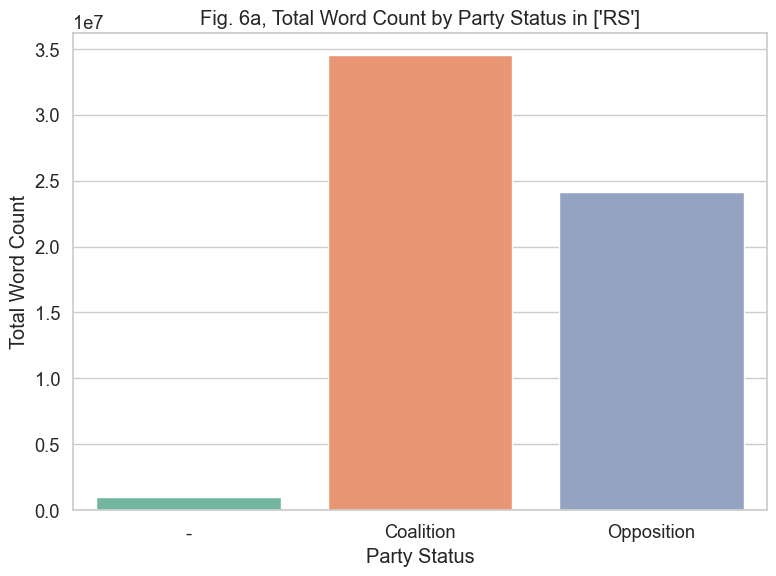

In [25]:
# ---- 1. Select the countries ----
selected_countries = ["RS"]
filtered_subset = filtered_all[filtered_all["country"].isin(selected_countries)].copy()

# ---- 2. Calculate total word count by party status ----
status_total_words = (
    filtered_subset
    .groupby("party_status", observed=True)["word_count"]
    .sum()
    .reset_index()
)

# ---- 3. Plot total word count by party status ----
plt.figure(figsize=(8, 6))
sns.barplot(
    data=status_total_words,
    x="party_status",
    y="word_count",
    palette="Set2" # Use a distinct palette from the sentiment plot
)

plt.title(f"Fig. 6a, Total Word Count by Party Status in {selected_countries}")
plt.xlabel("Party Status")
plt.ylabel("Total Word Count")
plt.tight_layout()
plt.show()

*As Figure 6a indicates, the Coalition contributes the most in the debates at the Serbian parliaments. This is different to a lot of other parliaments where usually the opposition is speaking more than the coalition.*

Having established the speaking volume of each group, we can now analyze the **sentiment distribution across party status (Fig. 6b)**. This helps to answer questions such as *Is the opposition or the coalition more negative in its tone?*

Here, we focus on one selected countries rather than the full dataset. At the top, there is an optional (commented-out) sections that allows you to change or add more countries you want to analyze together or even filter by a specific party, making it possible to explore coalition vs. opposition dynamics in greater detail.

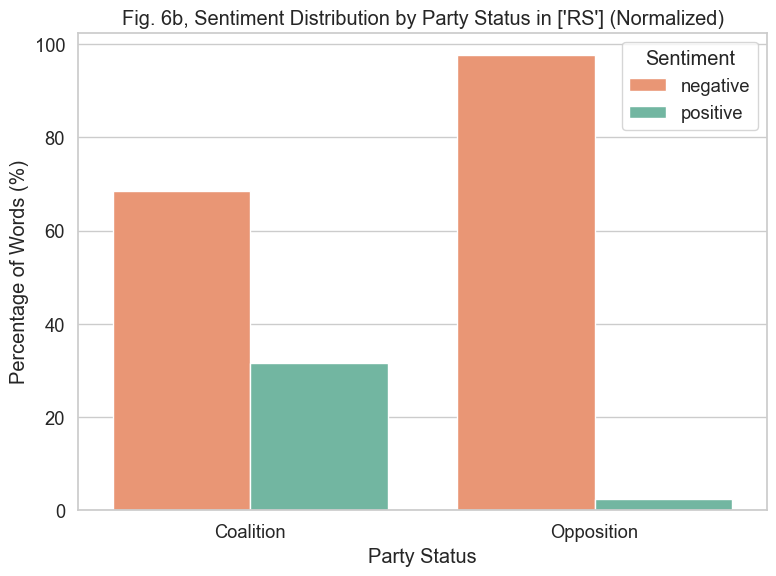

In [28]:
# ---- 1. Select the countries ----
selected_countries = ["RS"]
filtered_subset = filtered_all[filtered_all["country"].isin(selected_countries)].copy()

# ---- 2. Aggregate ----
status_word_counts = (
    filtered_subset
    .groupby(["party_status", "sent3_category"], observed=True)["word_count"]
    .sum()
    .reset_index()
)

# ---- 2.1 Normalize sentiment labels (case/whitespace) ----
status_word_counts["sent3_category"] = (
    status_word_counts["sent3_category"].astype(str).str.strip().str.lower()
)

# ---- 2.2 Filter out "-" status and neutral ----
status_word_counts = status_word_counts[
    (status_word_counts["party_status"] != "-") &
    (status_word_counts["sent3_category"] != "neutral")
]

# ---- 3. Percent within each party_status (over remaining sentiments) ----
totals = status_word_counts.groupby("party_status")["word_count"].transform("sum")
status_word_counts["percentage"] = status_word_counts["word_count"] / totals * 100

# ---- 4. Plot ----
set2 = sns.color_palette("Set2")
custom_palette = {
    "negative": set2[1],  # orange

    "positive": set2[0]   # green
}

plt.figure(figsize=(8, 6))
sns.barplot(
    data=status_word_counts,
    x="party_status",
    y="percentage",
    hue="sent3_category",
    hue_order=hue_order,
    palette=custom_palette
)

plt.title(f"Fig. 6b, Sentiment Distribution by Party Status in {selected_countries} (Normalized)")
plt.xlabel("Party Status")
plt.ylabel("Percentage of Words (%)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


*Figure 6b shows us that the Opposition in the Serbian parliament contributes a larger share of its speech to negative sentiment, whereas the Coalition contributes a relatively higher share to positive sentiment* 

*Future research could investigate whether this negativity is structural and can be found in a similar way in other parliaments. Additionally, examining how these patterns vary by topic or over time could provide deeper insights into parliamentary discourse dynamics.*

**4. Average Sentiment by Country & Topic**

To complement the previous distribution plots, we now summarize sentiment patterns quantitatively. For each country and topic, we calculate the average sentiment along with the total word count. The results are presented in a table, which can also be exported as a TSV file for further analysis.

In [ ]:
# ---- 1. Compute weighted avg sentiment and total word count ----
agg = (
    filtered_all
    .groupby(["country", "CAP_category"], observed=True)
    .apply(lambda x: pd.Series({
        "avg_sentiment": (x["sent_logit"] * x["word_count"]).sum() / x["word_count"].sum(),
        "total_words": x["word_count"].sum()
    }))
    .reset_index()
)

# ---- 2. Round the sentiment ----
agg["avg_sentiment"] = agg["avg_sentiment"].round(2)

# ---- 3. Ensure total_words is int ----
agg["total_words"] = agg["total_words"].astype(int)

# ---- 4. Optional: sort by country and CAP_category ----
agg = agg.sort_values(by=["country", "CAP_category"])

# ---- 5. Display the table ----
print(agg)

# ---- 6. Export to TSV for further research ----
output_path = "avg_sentiment_by_country_topic.tsv"
agg.to_csv(output_path, sep="\t", index=False)
print(f"\nTSV file saved as: {output_path}")

    country       CAP_category  avg_sentiment  total_words
0        AT        Agriculture           2.15      2263148
1        AT       Civil Rights           1.87      2840723
2        AT            Culture           2.24       767773
3        AT            Defense           1.87      1490495
4        AT  Domestic Commerce           2.16      2174178
..      ...                ...            ...          ...
639      UA              Other           2.68      1019710
640      UA       Public Lands           2.12       190139
641      UA     Social Welfare           2.36      1051246
642      UA         Technology           2.45       421939
643      UA     Transportation           2.33       447973

[644 rows x 4 columns]

TSV file saved as: avg_sentiment_by_country_topic.tsv


C:\Users\isabe\AppData\Local\Temp\ipykernel_19888\1507398074.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


*A table like this - with **average sentiment** and **total word count** per *country and topic* - opens up several useful analyses and visualizazions. For example, you could rank topics by sentiment within each country to see which topics are debated more positively or negatively. You could also compare countries and identify if certain topics (e.g. 'Macroeconomics' or 'Health') are framed more negatively in one country than another.*

Having summarized average sentiment and word counts by country and topic also allows us to shift to a more comparative perspective. In the next step, we will examine how strongly each topic features in parliamentary debates (its share of total words) and how that prominence relates to the tone of discussion. Basically, we will try to investigate the question *Are topics that are more commonly debated also debated more negatively?* 


**5. Topic Share vs. Sentiment across Countries (example: RS)**

By plotting topic share against average sentiment, we can visualize whether topics that dominate parliamentary discourse tend to be framed more positively, neutrally or negatively.

The code below aggregates the data of one selected country - here, **Serbia** - and gives us an overview of the overall discourse patterns in this country's parliament and to highlight topics that are in general more 'negative' or 'positive'.

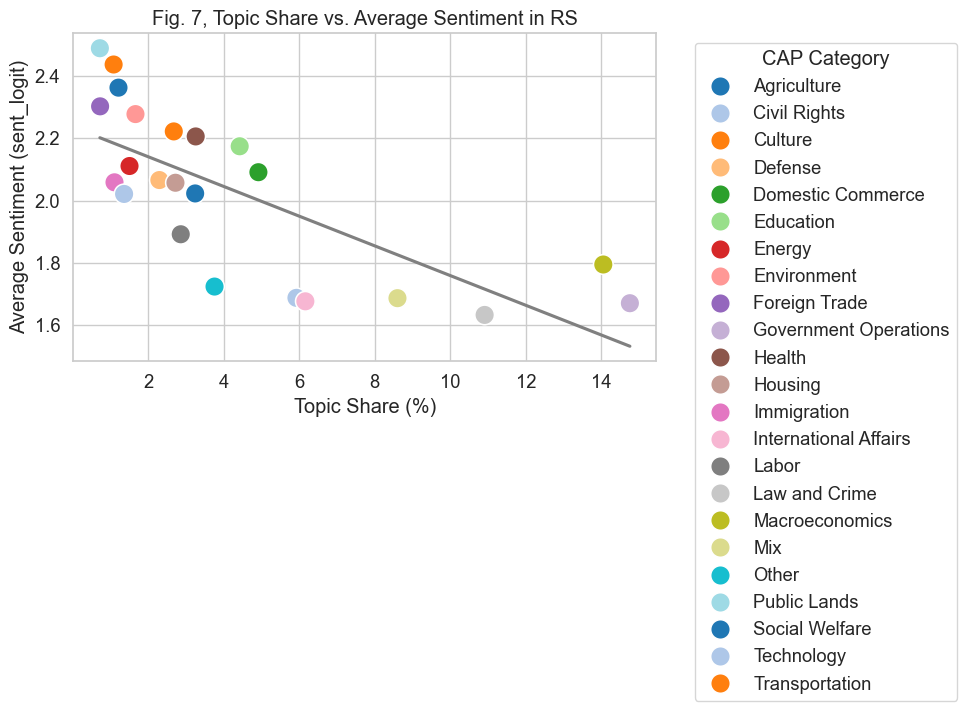

In [ ]:
# ---- 1. Optional: Filter for a single country (e.g., Serbia = "RS") ----
country_filter = "RS"   # set to None to use all countries
if country_filter:
    data_subset = filtered_all[filtered_all["country"] == country_filter].copy()
else:
    data_subset = filtered_all.copy()

# ---- 2. Aggregate across all countries ----
agg = (
    data_subset
    .groupby("CAP_category")[["sent_logit", "word_count"]]
    .agg(mean_sent=("sent_logit", "mean"),
         total_words=("word_count", "sum"))
    .reset_index()
)

# ---- 3. Calculate topic share across all countries ----
total_words = agg["total_words"].sum()
agg["topic_share_pct"] = (agg["total_words"] / total_words) * 100

# ---- 4. Scatter plot ----
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg,
    x="topic_share_pct",
    y="mean_sent",
    hue="CAP_category",
    palette="tab20",
    s=200
)

# Optional: add regression line
sns.regplot(
    data=agg,
    x="topic_share_pct",
    y="mean_sent",
    scatter=False,
    ci=None,
    color="gray"
)

title = (
    f"Fig. 7, Topic Share vs. Average Sentiment in {country_filter}"
    if country_filter else "Topic Share vs. Average Sentiment Across All Countries"
)
plt.title(title)
plt.xlabel("Topic Share (%)")
plt.ylabel("Average Sentiment (sent_logit)")
plt.legend(title="CAP Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


*Figure 7 shows a downward facing trend line, suggesting that topics receiving more attention tend to be discussed with a more negative tone. We can identify 'Government Operations', 'Macroeconomics' and 'Law and Crime' as the main drivers of this pattern which matches with our findings from Fig. 4 where we saw that these topics were not only the most discussed but also always dominated by negative speech.*

**6. Conclusion:**

This tutorial has provided a comprehensive exploratory analysis of the ParlaMint dataset, while addressing fundamental questions regarding the distribution of policy topics and sentiment across parliaments. The key findings reveal interesting patterns and indicate country-specific nuances in parliamentary discourse. In summary, we looked at:

- **CAP category patterns**: Topics such as 'Macroeconomics', 'Government Operations' and 'Law and Crime' dominate debates across the selected parliaments (RS, HR, HU).
- **Sentiment trends**: Neutral and negative sentiment generally dominate parliamentary debates. Positive tone is identified as the least common, indicating that parliaments are primarily criticism and heated discussions as a form of expression (rather than praise or affirmation).
- **Party & coalition influence**: In the analysis of Serbia (RS), coalition parties dominate the quantity of speech and tend to employ a more neutral tone, while opposition parties speak less overall and contribute a disproportionally high share of negative sentiment.
- **Topic prominence vs. sentiment**: The scatterplot reveals that topics receiving greater attention are discussed more negatively, though some countries might display a more balanced distribution if looked at separately.

In the next Tutorial (**Tutorial 3**), we will build on the descriptive analyses from this Tutorial and move towards a more comparative approach, using cosine distance to systematically measure how similar or different parliamentary discourses are across countries.